In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.metrics import mean_squared_error
import pandas_datareader as reader
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import LSTM


%matplotlib inline

In [3]:
end=dt.datetime.now()
start="28-06-2002"
df=reader.get_data_yahoo('AAPL',start,end)
df=df.reset_index()
df1=df['Open']

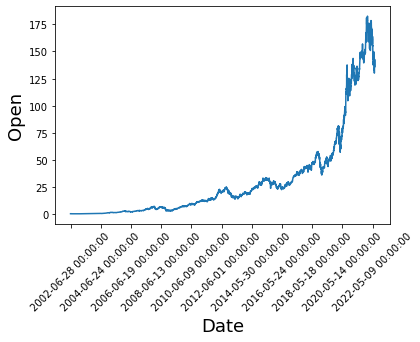

In [5]:
plt.plot(range(df.shape[0]),(df['Open']))
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Open',fontsize=18)
plt.show()

In [5]:
np.random.seed(3)
df1.reset_index
df2 = df1.values
df2 = df1.astype('float32')
df2=pd.DataFrame(df1)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_n = scaler.fit_transform(df2)

In [7]:
trainsize = int(len(df_n) * 0.8)
testsize = len(df_n) - trainsize
traindata = df_n[0:trainsize,:] 
testdata=df_n[trainsize:len(df_n),:]
print(len(traindata), len(testdata))

4028 1008


In [8]:
def create_dataset(data, look_back=1):
    data_X, data_Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        data_X.append(a)
        data_Y.append(data[i + look_back, 0])
    return np.array(data_X), np.array(data_Y)

In [9]:
Xtrain, Ytrain = create_dataset(traindata, 1)
Xtest, Ytest = create_dataset(testdata, 1)

In [12]:
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

In [13]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
4026/4026 - 15s - loss: 9.1511e-04
Epoch 2/5
4026/4026 - 5s - loss: 5.2389e-06
Epoch 3/5
4026/4026 - 5s - loss: 4.5781e-06
Epoch 4/5
4026/4026 - 5s - loss: 4.5199e-06
Epoch 5/5
4026/4026 - 6s - loss: 4.7699e-06


In [14]:
import math
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)
trainPredict = scaler.inverse_transform(trainPredict)
Ytrain = scaler.inverse_transform([Ytrain])
testPredict = scaler.inverse_transform(testPredict)
Ytest = scaler.inverse_transform([Ytest])
train_Score = math.sqrt(mean_squared_error(Ytrain[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (train_Score))
test_Score = math.sqrt(mean_squared_error(Ytest[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (test_Score))

Train Score: 0.31 RMSE
Test Score: 15.41 RMSE


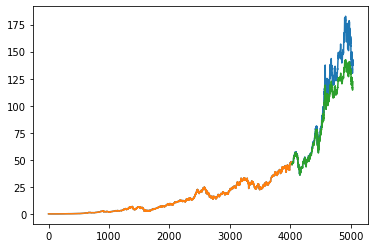

In [16]:
train_PredictPlot = np.empty_like(df_n)
train_PredictPlot[:, :] = np.nan
train_PredictPlot[1:len(trainPredict)+1, :] = trainPredict
# shift test predictions for plotting
test_PredictPlot = np.empty_like(df_n)
test_PredictPlot[:, :] = np.nan
test_PredictPlot[len(trainPredict)+(1*2)+1:len(df_n)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_n))
plt.plot(train_PredictPlot)
plt.plot(test_PredictPlot)
plt.show()